
<br>
<font>
<div dir=ltr align=center>
<img src="https://cdn.freebiesupply.com/logos/large/2x/sharif-logo-png-transparent.png" width=150 height=150> <br>
<font color=0F5298 size=7>
Linear Algebra <br>
<font color=3C99D size=5>
first practical exercise - ICA <br>
<font color=3C99D size=5>
Answer Notebook <br>
<font color=2565AE size=5>
Computer Engineering Department <br>
Fall 2024<br>
<font color=696880 size=4>
Alireza Malekhosseini
      
____

<font size = 4>
in this notebook you are going to use ICA (or independent component analysis) to solvd a famous problem called blind source localization.
you will learn more about this algorithm in the machine learning course.

Independent Component Analysis (ICA) is a computational technique for separating a multivariate signal into additive, independent components. ICA is called "Independent Component Analysis" because its goal is to transform a set of observed variables into statistically independent components, each representing a distinct underlying source in the data.

imagine 3 different pictures of three different entities (like a human, an apple and a guitar), and now imagine that these three pictures have been combined together using a mean over all three pictures. now if you have enough (at least 3) of these combined pictures that in each combined pictures, different weights for sources have been used, you can retrive the source images using an ICA algorithm.

- **note that your code in this notebook must be fully reproducible**

### How ICA Works
<font size = 4>
ICA assumes that the observed data are linear mixtures of some unknown independent sources. The objective is to identify both the original sources and the mixing process, even when the sources are not directly observable. ICA typically relies on the statistical property of independence, where each recovered signal is assumed to be non-Gaussian and as independent as possible from the others.

Mathematically, if $\mathbf{X}$ is the observed signal matrix, then the goal of ICA is to find a matrix $\mathbf{W}$ such that:
$\mathbf{S} = \mathbf{W} \cdot \mathbf{X} $
where:
- $\mathbf{X} \in \mathbb{R}^{N \times M}$ is the observed signal in which every row is one of the sample mixed signals. so M is the length of every sample signal.
- $\mathbf{S} \in \mathbb{R}^{C \times M}$ is the matrix of independent components (the separated sources) and C is the number of Components or sources that is to be extracted.
- $\mathbf{W} \in \mathbb{R}^{N \times C}$ is the unmixing matrix of shape that needs to be learned.





<font size = 4>
TODO: seach about different use cases of ICA and write a brief explanation about them here.

<font size = 4>
answer:

## Introduction to FastICA

<font size = 4>
FastICA is a popular and efficient algorithm for performing ICA. It is based on a fixed-point iteration scheme and aims to find the independent components more quickly than traditional methods. FastICA is widely used because it converges faster and is computationally more efficient.


<font size = 4>
do a little research about Non-Gaussianity Maximization used in FastICA and explain its relation to Centeral Limit Theorem.

answer:

<font size=4>
in this notebook we are going to use FastICA algorithm for a blind source localization task on audio files. the audio files are placed in the data folder beside the notebook.
    
the algorithm has been fully explained the the wikipedia page bellow and we're going to implement the exact algorithm here in this notebook.\
<a href="https://en.wikipedia.org/wiki/FastICA" style="font-size:20px; color:#3d2b1f;">FastICA Wikipedia Page</a>


In [ ]:
import numpy as np
from numpy.linalg import eigh

import matplotlib.pyplot as plt
import soundfile as sf

from scipy.io import wavfile
from scipy.signal import resample
from sklearn.decomposition import FastICA
from IPython.display import Audio

In [ ]:
def plotSounds(sound_list, name_list, samplerate):
	"""Plots the sounds as a time series data"""

	times = np.arange(len(sound_list[0]))/float(samplerate)

	fig = plt.figure(figsize=(15,4))
	imageCoordinate = 100 + 10*len(sound_list) + 1
	i = 0

	for sound in sound_list:
		fig.add_subplot(imageCoordinate)
		plt.fill_between(times, sound, color='k')
		plt.xlim(times[0], times[-1])
		plt.title(name_list[i])
		plt.xlabel('time (s)')
		plt.ylabel('amplitude')
		# plt.axis("off")
		plt.plot(sound)

		imageCoordinate += 1
		i += 1

	plt.show()

In [ ]:
#at first load the mixed audio files in the sounds folder and put them together using vstack function from numpy to form the X matrix explained above
rate1, data1 = wavfile.read('sounds/mixed1.wav')
rate2, data2 = wavfile.read('sounds/mixed2.wav')
rate3, data3 = wavfile.read('sounds/mixed3.wav')
X = np.vstack((data1, data2, data3))

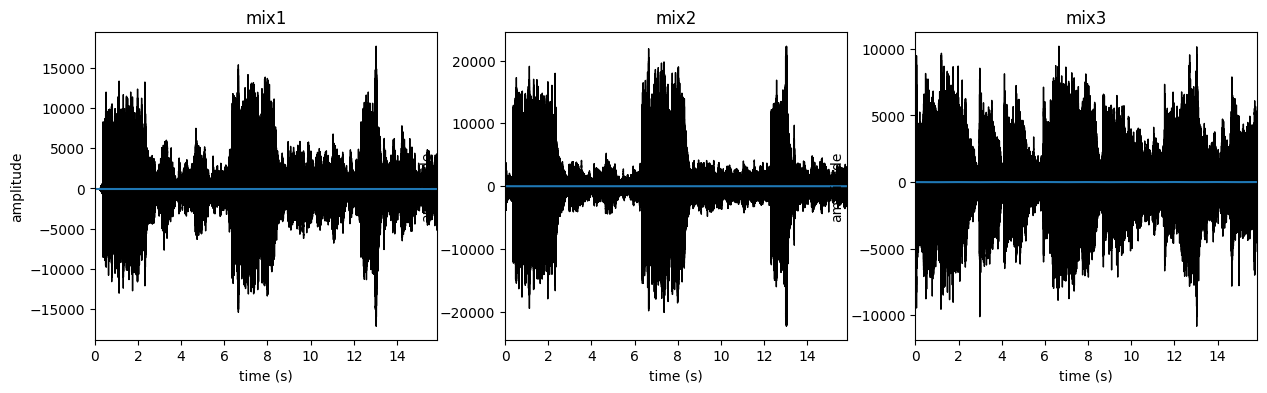

In [ ]:
#plot the mixed signals using the plot function.
plotSounds([data1, data2, data3], ['mix1', 'mix2', 'mix3'], rate1)

In [ ]:
#TODO play the first two  using IPython.display class
Audio(data1, rate=rate1)
Audio(data2, rate=rate2)


## prewhitening the data

<font size = 3>
first you should shift every mixed sample signal to a zero mean. after this step the mean of every row of the data must be zero.


In [ ]:
X_centered = X - X.mean(axis=1)[:, np.newaxis]

## whitening the data

<font size = 4>
before performing FastICA algorithm first we need to do whiten the data. this mean applying a linear transformation on the data so that without

Whitening is a preprocessing step used to transform data so that the resulting variables are uncorrelated and have unit variance. In simpler terms, whitening decorrelates the features and normalizes them to have the same scale. When data is zero-centered, whitening makes the covariance matrix of the data an identity matrix.


#### **Covariance Matrix**:
The covariance matrix is a key concept in whitening. For a zero-centered dataset $X$ with $n$ samples and $d$ features, the covariance matrix $C$ is computed as:
<p style="text-align:center;font-size:24px">$C = \frac{1}{n} X^T X$</p>



Where:
- $\mathbf{X}$ is the $n \times d$ data matrix (rows are samples, columns are features).
- $\mathbf{X^T}$ is the transpose of $\mathbf{X}$.

The covariance matrix $\mathbf{C}$ describes how the features in the data vary with each other. Each element $\mathbf{C_ij}$ of the covariance matrix represents the covariance between the $i$-th and $j$-th signals.

#### 3. **Whitening Transformation**:
Whitening modifies the data so that its covariance matrix becomes the **identity matrix**. In the identity matrix, the diagonal entries are all 1 (indicating unit variance for each feature), and the off-diagonal entries are 0 (indicating no correlation between features).

To achieve this, we use **eigenvalue decomposition** (EVD) or **singular value decomposition** (SVD) to decompose the covariance matrix. we know that these two decompositions are the same if the matrix is symmetric and positive semidefinite, and hence the covariance matrix meets both criteria, it has the same SVD and EVD decomposition.

The covariance matrix $C$ can be decomposed as:
<p style="text-align:center;font-size:24px">$C = V \Lambda V^T$</p>


Where:
- $V$ is a matrix of eigenvectors (orthogonal basis of the data space).
- $\Lambda$ is a diagonal matrix of eigenvalues, representing the variance along the principal directions.

Whitening involves transforming the data using the eigenvalues and eigenvectors from this decomposition:

<p style="text-align:center;font-size:24px">$X_{\text{whitened}} = \Lambda^{-\frac{1}{2}} V^T X$</p>




Where:
- $\Lambda^{-\frac{1}{2}}$ is the inverse square root of the eigenvalue matrix, which normalizes the data by the variance in each principal direction. (we know that all the eigenvalues of the covariance matrix are nonnegative.)
- $V^T$ aligns the data with the new orthogonal basis, and $\Lambda^{-\frac{1}{2}}$ scales it.

### How Whitening Works
- **Data decorrelation**: The eigenvalue decomposition aligns the data along the directions where the variance is highest. These directions are the eigenvectors of the covariance matrix.
- **Normalization**: After the alignment, the eigenvalue matrix $\Lambda$ scales the data by the variance in each direction. By multiplying by the inverse square root of $\Lambda$, the variances are normalized to 1, leading to unit variance along each axis.

### Covariance Matrix After Whitening

Once the data is whitened, the covariance matrix of the whitened data becomes the **identity matrix**:



<p style="text-align:center;font-size:24px">$\text{Cov}(X_{\text{whitened}}) = I$</p>


This means:
- The features are uncorrelated (off-diagonal elements are zero).
- The variance of each feature is 1 (diagonal elements are one).

#### Covariance Proof After Whitening:

TODO: Given the whitening transformation $X_{\text{whitened}} = X V \Lambda^{-\frac{1}{2}}$, prove that the covariance matrix of the whitened data is equal to Identity matrix

answer:

### Computing $\Lambda^{-1/2}$ and $X^{-1/2}$ (although not used here)
<font size=4>
we know that the covariance matrix is a positive semi-definite matrix. you can check out the proof in this link:
<a href="https://math.stackexchange.com/questions/114072/what-is-the-proof-that-covariance-matrices-are-always-semi-definite" style="font-size:20px; color:#3d2b1f;">Proof that the Covariance matrix is PSD</a>


For a positive semi-definite matrix, instead of the inverse, we can compute the **Moore-Penrose pseudoinverse** of the square root, which involves taking the reciprocal of only the non-zero eigenvalues.

In this case, the decomposition $X = Q \Lambda Q^T$ is still used, but we construct $\Lambda^{-1/2}$ such that:

$\Lambda^{-1/2} = \text{diag} \left(
\begin{cases}
\frac{1}{\sqrt{\lambda_i}} & \text{if } \lambda_i > 0, \\
0 & \text{if } \lambda_i = 0
\end{cases}
\right)$

The resulting matrix $Y = X^{-1/2}$ defined by: $X^{-1/2} = Q \Lambda^{-1/2} Q^T$ is a well-defined pseudoinverse square root for X.


based on the above explanation complete the cell bellow to define the whitening function. do not use any of the np.linalg functions for computing $\Lambda^{-1/2}$

In [ ]:
def whitenMatrix(matrix):
    """The transformation for the matrix X is given by E*D^(-1/2)*transpose(E)*X
    Where D is a diagonal matrix containing eigen values of covariance matrix of X
    E is the matrix containing eigen vectors of covariance matrix of X"""

    n_samples = matrix.shape[1]
    cov_matrix = np.dot(matrix, matrix.T) / n_samples

    eigenValue, eigenVector = np.linalg.eigh(cov_matrix)

    idx = eigenValue.argsort()[::-1]
    eigenValue = eigenValue[idx]
    eigenVector = eigenVector[:, idx]
    diag = np.diag(1.0 / np.sqrt(eigenValue + 1e-10))

    whiteMatrix = np.dot(np.dot(np.dot(eigenVector, diag), eigenVector.T), matrix)

    return whiteMatrix

In [ ]:
#whiten the centered data using the whitenMatrix function
X_whitened =  whitenMatrix(X_centered)

### The FastICA algorithm
<font size=4>

Once the data is whitened, we can apply the FastICA algorithm on it. complete the bellow cell to implement the FastICA algorithm for sorce localization of a mixed sound. the algorithm is exactly provided in this page:
<a href="https://en.wikipedia.org/wiki/FastICA" style="font-size:20px; color:#3d2b1f;">FastICA Wikipedia Page</a>. check out the multi-component extraction and try to implement it here.





In [ ]:
class FastICA:
    def __init__(self, eps=1e-5, max_iter=1000):
        self.eps = eps
        self.max_iter = max_iter

    def f0(self, u):
        return np.tanh(u)

    def f1(self, u):
        return 1 - np.tanh(u) ** 2

    def f2(self, u):
        return -2 * np.tanh(u) * (1 - np.tanh(u) ** 2)

    def fit_transform(self, X, n_components):
        vectors = []
        n_features = X.shape[0]

        for i in range(n_components):
            # بردار وزن اولیه رو به صورت یک ستون می‌سازیم
            w1 = np.random.rand(n_features)  # تغییر این خط
            w1 = w1 / np.sqrt(np.sum(w1 ** 2))
            w2 = np.zeros_like(w1)  # تغییر این خط

            count = 0
            # حلقه همگرایی
            while np.abs(1 - np.abs(np.dot(w1, w2))) > self.eps and count < self.max_iter:
                w2 = w1.copy()

                # محاسبه جمله اول
                u = np.dot(w2, X)
                first_term = np.mean(X * self.f0(u), axis=1)

                # محاسبه جمله دوم
                second_term = np.mean(self.f1(u)) * w2

                # به‌روزرسانی وزن
                w1 = first_term - second_term

                # گرام-اشمیت
                for v in vectors:
                    w1 = w1 - np.dot(v, w1) * v

                # نرمال‌سازی
                w1 = w1 / np.sqrt(np.sum(w1 ** 2))

                count += 1

            vectors.append(w1)

        # تبدیل لیست بردارها به ماتریس
        W = np.array(vectors)
        # محاسبه مولفه‌های مستقل
        S = np.dot(W, X)

        return W, S

In [ ]:
# سفیدسازی داده‌ها
X = whitenMatrix(centered_audio_array)

# ساخت نمونه FastICA
ica = FastICA(eps=1e-5)

# استخراج 3 مؤلفه مستقل
W, S = ica.fit_transform(X, n_components=3)

print("Weight matrix W shape:", W.shape)
print("Independent components S shape:", S.shape)

Weight matrix W shape: (3, 3)
Independent components S shape: (3, 506880)


<font size = 4>
now play the sources extracted by the FastICA algorithm using the IPython library and also compute the cosine similarity between these sources and display it

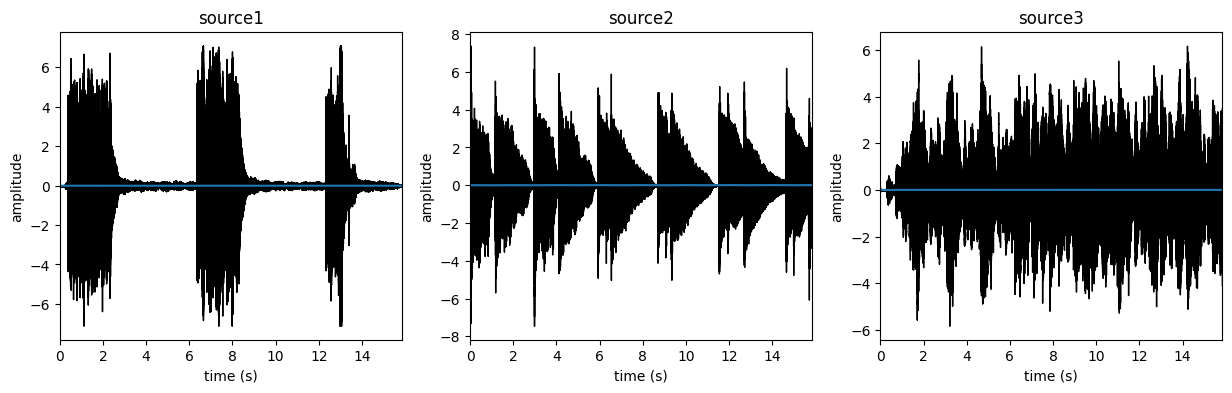

In [ ]:
#plot the mixed signals using the plot function.
plotSounds(S, ['source1', 'source2', 'source3'], rate1)

In [ ]:
#play the first source
Audio(S[0], rate=rate1)

In [ ]:
#play the second source
Audio(S[1], rate=rate1)

In [ ]:
#play the third source
Audio(S[2], rate=rate1)